
TFG

Este es el codigo del tfg de Borja Jimeno

En esta primera celda vamos a definir todas las funciones y variables que necesitaremos para calcular el ritmo teórico. Cada función está explicada al inicio y cada variable tiene asociadas sus unidades en un comentario a la derecha.  

Para la realización de las funciones se ha tomado como referencia:  
-El pdf ('rateTutorial_MMartinez_TAE25.pdf)    
-El capítulo 7 de la Tesis de María ('tesisMaria_chap7.pdf')   
-El artículo 'Inelastic and Elastic Scattering of 187-Mev Electrons from Selected Even-Even Nuclei - Richard Helm - PHISICAL REVIEW VOLUME 104, NUMBER 5 DECEMBER 1, 1956'  
-Para calcular el Quenching Factor, Sección 4.3.2 de la tesis de Tamara Pardo Yanguas ('Tesis-Tamara.pdf')

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm

from funciones_ritmo_teorico import*
from funciones_ritmo_exp import*


plt.rcParams['font.size'] = 18


## Plots de exclusion

Para dibujar los plots de exlusion necesitamos obtener la funcion $\sigma_{si}(m_{\chi})$ que nos da los valores de la seccion eficaz para la que, dada una masa del WIMP (GeV), el numero de cuentas teorico coincide con el numero de cuentas experimental. Recordando las expresiones de los otros cuadernos:

$$N_{teo}=N_{exp}$$

Con el numero de cuentas teorico descrito con la expresion:

$$N_{teo}\left[cts\right]= \frac{A_{Na} \cdot R_{Na} + A_{I} \cdot R_{I}}{A_{Na}+A_{I}} $$

Tenemos que la seccion eficaz es un factor multiplicativo y por tanto puede salir como factor comun si evaluamos las funciones en seccion eficaz unidad.

$$R_j=\sigma_{SI}\cdot R_j (\sigma_{SI}=1\textup{ cm})$$

Por tanto la expresion final del numero de cuentas teorico queda:

$$N_{teo}= \sigma_{SI}\frac{A_{Na} \cdot R_{Na}(\sigma_{SI}=1\textup{ cm}) + A_{I} \cdot R_{I}(\sigma_{SI}=1\textup{ cm})}{A_{Na}+A_{I}} =\sigma_{SI} N_{teo}(\sigma_{SI}=1)$$

Despejando de la primera igualdad obtenemos la expresion para la seccion eficaz:

$$\sigma_{SI} N_{teo}(\sigma_{SI}=1)=N_{exp} \longrightarrow \boxed{\sigma_{SI}=\frac{N_{exp}}{N_{teo}(\sigma_{SI}=1)}}$$







In [2]:
def calcula_sigma(E_i,E_f,mW,t,cl=0.9,array_det=np.ones(9,dtype=int)):
    texp=calcula_t_exposicion(array_det)
    mexp=calcula_m_exposicion(array_det)
    N_exp=numero_cuentas_exp_CL(E_i,E_f,cl,array_det)
    N_teo=numero_cuentas_teo(E_i,E_f,t,mW,1,texp,mexp)
    return N_exp/N_teo
    


## Dependencia con la exposicion

La seccion eficaz del plot de exclusion depende de la exposicion de la siguiente forma:

$$\sigma_{SI}=\frac{N_{exp}}{N_{teo}(\sigma_{SI}=1)}\propto \frac{M_{det} \cdot T_{exp}+1.28\sqrt{M_{det} \cdot T_{exp}}}{M_{det} \cdot T_{exp}}\propto \left(1+\frac{1.28}{M_{det} \cdot T_{exp}}\right)$$


/tmp/ipykernel_13293/3660250933.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return N_exp/N_teo


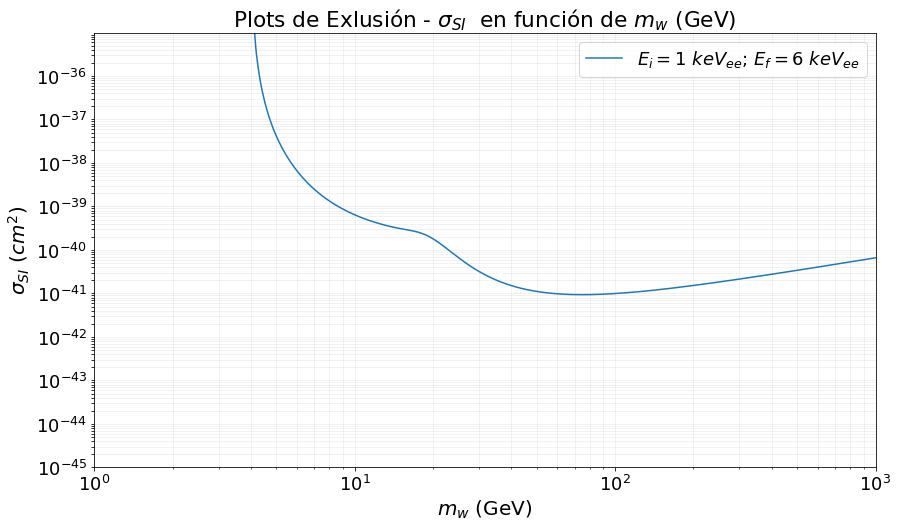

In [3]:

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW_min=0.1 #masa wimp minima en GeV
mW_max=3

mWs=np.logspace(mW_min,mW_max,num=1000,endpoint=True)

#Calculamos función Numero de Cuentas teorico

Ei=1
Ef=6

sigmas=np.zeros(len(mWs))

for i in range (len(mWs)):
    sigmas[i]=calcula_sigma(Ei,Ef,mWs[i],timeAvg)



plt.figure(figsize=(14, 8))
ax = plt.subplot()

ax.plot(mWs,sigmas,label="$E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")

ax.legend()
ax.set_title(r'Plots de Exlusión - $\sigma_{SI}$  en función de $m_w$ (GeV)')
ax.set_ylabel(r'$\sigma_{SI}$ $(cm^2)$',fontsize=20)
ax.set_xlabel(r'$m_w$ (GeV)',fontsize=20)

ax.set_yscale("log")
ax.set_xscale("log")

y_sup=1e-35
y_inf=1e-45

ax.set_ylim(y_inf,y_sup)
ax.set_xlim(1,1000)

exp_min = int(np.floor(np.log10(y_inf)))   
exp_max = int(np.ceil(np.log10(y_sup)))    
exps = np.arange(exp_min, exp_max)     


all_ticks = []
for e in exps:
    decade = (np.arange(1, 10) * (10.0**e)).tolist()
    all_ticks.extend(decade)
all_ticks = np.array(all_ticks)

ax.set_yticks(all_ticks)                    

ax.grid(which='both', linestyle='-', alpha=0.2)

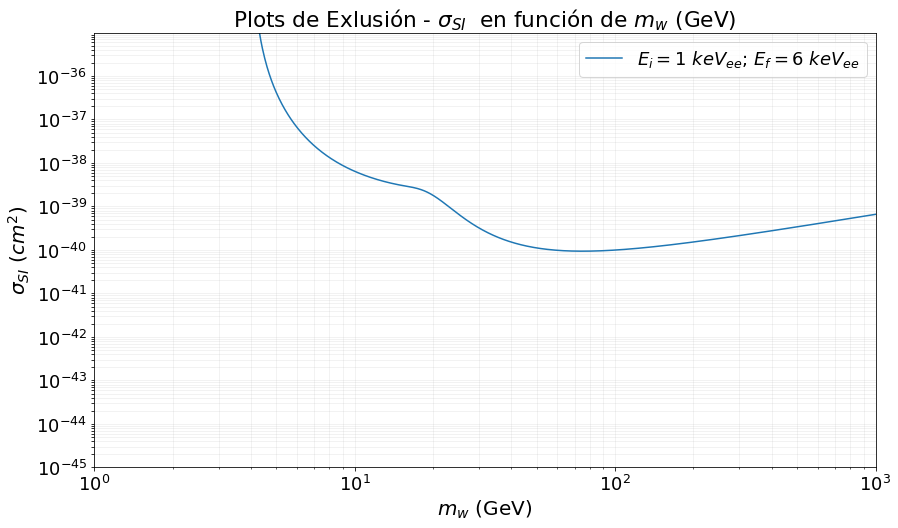

In [4]:
plt.figure(figsize=(14, 8))
ax = plt.subplot()

ax.plot(mWs,10*sigmas,label="$E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")

ax.legend()
ax.set_title(r'Plots de Exlusión - $\sigma_{SI}$  en función de $m_w$ (GeV)')
ax.set_ylabel(r'$\sigma_{SI}$ $(cm^2)$',fontsize=20)
ax.set_xlabel(r'$m_w$ (GeV)',fontsize=20)

ax.set_yscale("log")
ax.set_xscale("log")

y_sup=1e-35
y_inf=1e-45

ax.set_ylim(y_inf,y_sup)
ax.set_xlim(1,1000)

exp_min = int(np.floor(np.log10(y_inf)))   
exp_max = int(np.ceil(np.log10(y_sup)))    
exps = np.arange(exp_min, exp_max)     


all_ticks = []
for e in exps:
    decade = (np.arange(1, 10) * (10.0**e)).tolist()
    all_ticks.extend(decade)
all_ticks = np.array(all_ticks)

ax.set_yticks(all_ticks)                    

ax.grid(which='both', linestyle='-', alpha=0.2)